# Introduction
In this notebook, we will be doing a sentiment analysis on the AMAZON fine food reviews and explore different techniques to compare results of accuracy and speed:
1. VADER (Valence Aware Dictionary and Sentiment Reasoner) = Machine Learning (ML)
2. RoBERTa (Robustly Optimized BERT-Pretraining Approach) = large language model (LLM)


### Dataset
Download data at: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Note: 
- In this example, the review score is corresponding to the polarity of (1-2 = negative, 3 = neutral, 4-5 = positive)
- For the predicted score of both techniques, the compound score will be correspond to (<= -0.05 = negative, -0.05 < x < 0.05 = neutral, >= 0.05 = positive)


In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from spacy.lang.en import STOP_WORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from collections import Counter 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#roBERTa
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

plt.style.use('ggplot')

# Read data

In [2]:
# outputs
cols = ['Id', 'review comment', 'review score', 'tot_len', 'pos', 'neu', 'neg', 'compound']

#output_name_xls ='enron_email_clean.xlsx'
#output_name_csv ='enron_email_clean.csv'
data_name = 'Data/archive/Reviews.csv'

# total numbers of data to review, specify None if want to read whole file
read_rows = 1000 

In [3]:
# read data
data_df  = pd.read_csv(data_name)

# Explore data 

In [4]:
# load spacy
spacy_nlp = spacy.load('en_core_web_sm')

In [5]:
# total rows and columns
data_df.shape

(568454, 10)

In [6]:
# columns
data_df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
# get top x of the data
if read_rows == None:
    df = data_df
else:
    df = data_df.head(read_rows)

Text(0.5, 1.0, 'Count of Score')

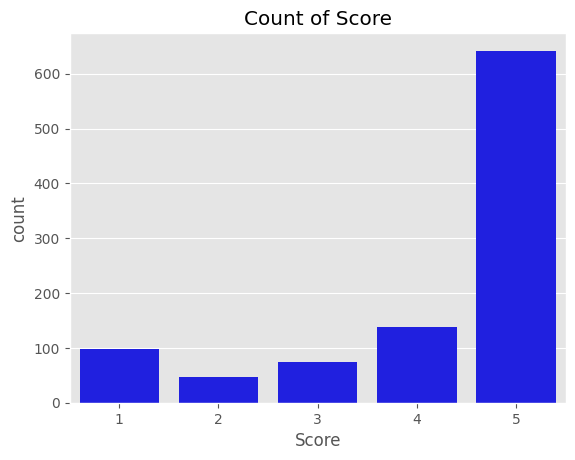

In [8]:
# check count by review
sns.countplot(x=df['Score'], color='b')
plt.title('Count of Score')

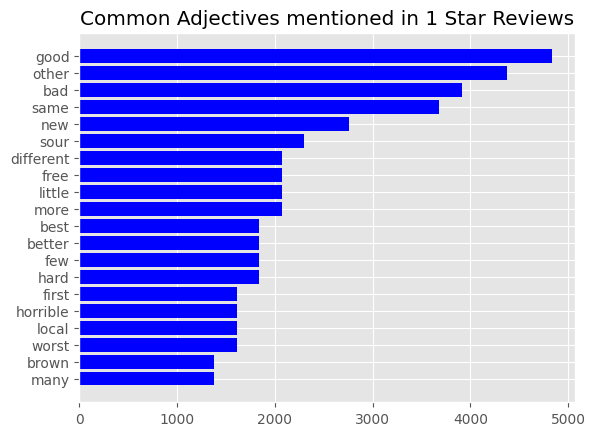

In [9]:
# check most common adjectives mentioned for the 1 star review
OneStardf = df[df['Score'] == 1]
doc = spacy_nlp(''.join(str(OneStardf.Text.tolist())))

 #list to use for storing adjectives in 1 star review 
OneStarAdj = [] 
for token in doc:
    if token.pos_ == 'ADJ': 
        for ent in list(doc.ents):
            if ent.label_ not in STOP_WORDS: 
                OneStarAdj.append(str(token))
            
#sort the list for better readability     
sorted_list = sorted(OneStarAdj, key=str)

new_list = np.asarray(Counter(sorted_list).most_common(20))

# plot result
fig, ax = plt.subplots()
plt.barh(new_list[:,0], [int(x) for x in new_list[:,1]], color = 'blue', align='center') 
ax.invert_yaxis()
plt.title('Common Adjectives mentioned in 1 Star Reviews')
plt.show()

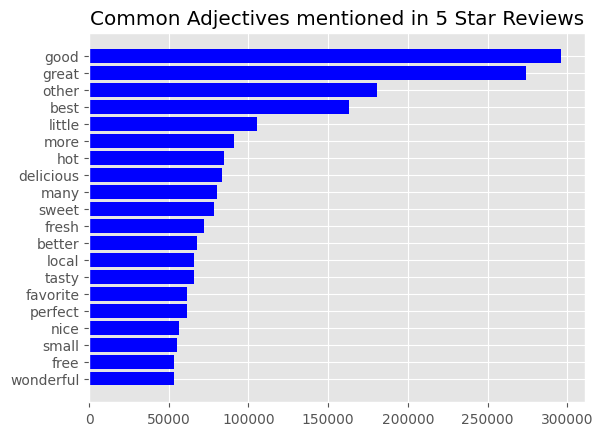

In [11]:
# check most common adjectives mentioned for the 5 star review
FiveStardf = df[df['Score'] == 5]
doc = spacy_nlp(''.join(str(FiveStardf.Text.tolist())))

 #list to use for storing adjectives in 5 star review 
FiveStardf = [] 
for token in doc:
    if token.pos_ == 'ADJ': 
        for ent in list(doc.ents):
            if ent.label_ not in STOP_WORDS: 
                FiveStardf.append(str(token))
            
#sort the list for better readability     
sorted_list = sorted(FiveStardf, key=str)

new_list = np.asarray(Counter(sorted_list).most_common(20))

# plot result
fig, ax = plt.subplots()
plt.barh(new_list[:,0], [int(x) for x in new_list[:,1]], color = 'blue', align='center') 
ax.invert_yaxis()
plt.title('Common Adjectives mentioned in 5 Star Reviews')
plt.show()

# VADER Scoring
The VADER sentiment analyser uses a lexical approach. That means it uses words or vocabularies that have been assigned predetermined scores as positive or negative.

Remark of VADER
1. A bag-of-word type model
2. Takes each word and scored individually, and combined to total score
3. This does not account relationship words

In [45]:
#nltk.download('vader_lexicon')

In [12]:
# call the VADER object
analyser = SentimentIntensityAnalyzer()

In [13]:
#Sentiment scoring
def sentiment_tag(x):
    if x>= 0.05:
        return "Positive"
    elif x<= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [14]:
review_data_list = []

for i, row in tqdm(df.iterrows(), total=len(df)):

    # get the review comment and id
    review_text = row['Text']
    review_id = row['Id']
    review_score = row['Score']
    
    # get total length of the body
    #tot_len = 0
    tot_len =len(review_text)
    
    # lemmatization, remove stop words, spaces and punctuation
    # token.text = original text, token.lemma_ = lemmatization
    #tokens = [token.lemma_ for token in doc if not token.is_stop | token.is_punct | token.is_space]
    result = analyser.polarity_scores(review_text)
                
    # append results
    review_data_list.append([review_id, review_text, review_score,
                             tot_len, result['pos'], result['neu'], result['neg'], result['compound']])
    
    

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.48it/s]


It takes 3 seconds to score 1000 reviews from VADER. averaging 310 reviews per second on a standard CPU computer

In [15]:
# create dataframe for vader scores
review_data_vader = pd.DataFrame(review_data_list, columns=cols)

# Change 0-5 to negative, neutral and positive
labels = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
review_data_vader['sentiment_review'] = review_data_vader['review score'].map(labels)

# apply sentiment tag based on the compound score from VADER
review_data_vader['sentiment_vader'] = review_data_vader['compound'].apply(sentiment_tag)

In [16]:
review_data_vader.head(5)

,Id,review comment,review score,tot_len,pos,neu,neg,compound,sentiment_review,sentiment_vader
0,1,I have bought several of the Vitality canned d...,5,263,0.305,0.695,0.000,0.9441,Positive,Positive
1,2,Product arrived labeled as Jumbo Salted Peanut...,1,190,0.000,0.862,0.138,-0.5664,Negative,Negative
2,3,This is a confection that has been around a fe...,4,509,0.155,0.754,0.091,0.8265,Positive,Positive
3,4,If you are looking for the secret ingredient i...,2,219,0.000,1.000,0.000,0.0000,Negative,Neutral
4,5,Great taffy at a great price. There was a wid...,5,140,0.448,0.552,0.000,0.9468,Positive,Positive


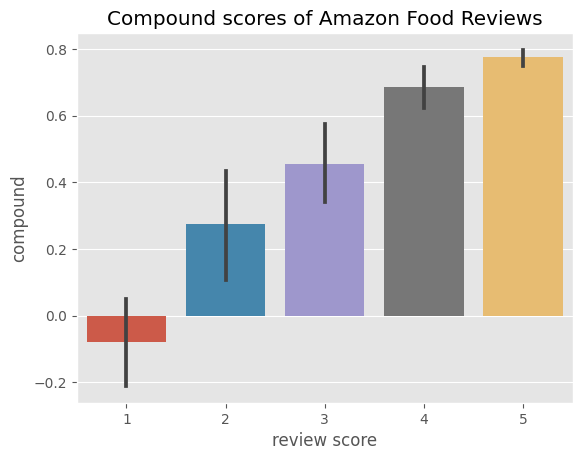

In [17]:
ax=sns.barplot(data=review_data_vader,x='review score',y='compound')
ax.set_title('Compound scores of Amazon Food Reviews')
plt.show()

The plot above shows that lower star review has a lower compound score while higher star review has a higher compound score, which shows that VADER gets it mostly right 

Accuracy: 0.811

              precision    recall  f1-score   support

    Negative       0.61      0.46      0.52       145
     Neutral       0.22      0.08      0.12        75
    Positive       0.86      0.95      0.90       780

    accuracy                           0.81      1000
   macro avg       0.56      0.49      0.51      1000
weighted avg       0.77      0.81      0.79      1000



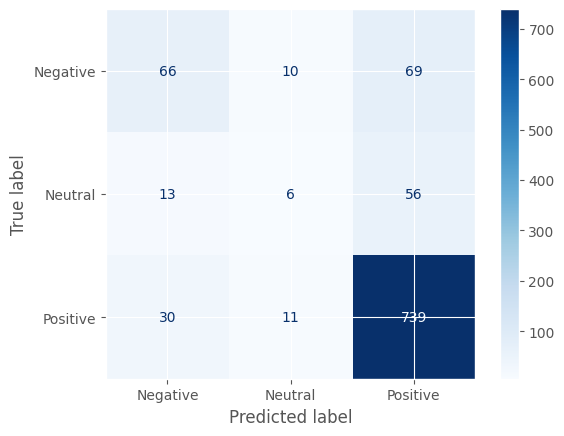

In [18]:
# Calculate the accuracy of VADER prediction
accuracy = accuracy_score(review_data_vader['sentiment_review'], review_data_vader['sentiment_vader'])

print("Accuracy: {}\n".format(accuracy))

# Show the classification report
print(classification_report(review_data_vader['sentiment_review'], review_data_vader['sentiment_vader']))

# show confusion matrix
target_names = ['Negative', 'Neutral', 'Positive'] #goes from 0 - 5 
cm = confusion_matrix(review_data_vader['sentiment_review'], review_data_vader['sentiment_vader'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [82]:
# checking 1-2 star review but predicted 4-5 star by vader
rand_numb =4 
example = review_data_vader[(review_data_vader['sentiment_review']== 'Negative') & 
                            (review_data_vader['sentiment_vader'] == 'Positive')].reset_index()

print("Rating from user: %d" % example['review score'][rand_numb])
print(example['review comment'][rand_numb])

Rating from user: 1
No tea flavor at all. Just whole brunch of artifial flavors. It is not returnable. I wasted 20+ bucks.


# RoBERTa scoring 
RoBERTa (Robustly Optimized BERT-Pretraining Approach), is a pre-trained moddel by hugging faces. Transformers is the python library for hugging faces 

Remark of RoBERTa
1. Trained on a massive dataset that spans over 160GB of uncompressed text, and it is trained with full sentences
2. Transformer model not only accounts for the words but also the context related to other words
3. It can show the polarity of the overall idea of the author, and guess sarcasm and hidden criticism.

In [22]:
# pull a model that is pre-trained on large data (twitter comments)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\cyber\.julia\conda\3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cyber\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [83]:
# VADER results on example where rating was 1 but VADER gave a positive instead
example = review_data_vader[(review_data_vader['sentiment_review']== 'Negative') & 
                            (review_data_vader['sentiment_vader'] == 'Positive')].reset_index()
vaderPosOneStarRating = example['review comment'][4]

print("Rating from user: %d" % example['review score'][4])
print(example['review comment'][rand_numb])
analyser.polarity_scores(vaderPosOneStarRating)

Rating from user: 1
No tea flavor at all. Just whole brunch of artifial flavors. It is not returnable. I wasted 20+ bucks.


{'neg': 0.106, 'neu': 0.768, 'pos': 0.126, 'compound': 0.1098}

In [84]:
# let's see what Roberta model predict
labels = ['Negative', 'Neutral', 'Positive']
encoded_text = tokenizer(vaderPosOneStarRating, return_tensors='pt') #pt = pytorch
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {}
for i in range(len(scores)):
    l = labels[i]
    s = scores[i]
    scores_dict[l] = s
print("RoBERTa predict result on 1 star review:")
print(scores_dict)

RoBERTa predict result on 1 star review:
{'Negative': 0.94413835, 'Neutral': 0.050167944, 'Positive': 0.005693673}


RoBERTa does not compute a compound score like VADER, hence we compare the 3 probabilities and the highest will become the sentiment of the review

In [40]:
# run RoBERTa model on the sample data
review_data_list2 = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        # get the review comment and id
        review_text = row['Text']
        review_id = row['Id']
        review_score = row['Score']

        # get total length of the body
        #tot_len = 0
        tot_len =len(review_text)

        # run RoBERTa model
        encoded_text = tokenizer(review_text, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

        # append results
        review_data_list2.append([review_id, review_text, review_score,
                                 tot_len, scores[2], scores[1], scores[0], 0])
    
    except RuntimeError:
        print(f'Broke for id {review_id}')
    

  8%|██████▌                                                                         | 82/1000 [00:22<02:46,  5.51it/s]

Broke for id 83


 19%|██████████████▊                                                                | 188/1000 [00:50<02:25,  5.56it/s]

Broke for id 187


 53%|█████████████████████████████████████████▋                                     | 528/1000 [02:34<03:24,  2.31it/s]

Broke for id 529


 54%|██████████████████████████████████████████▌                                    | 539/1000 [02:37<01:42,  4.50it/s]

Broke for id 540


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [03:41<02:01,  2.09it/s]

Broke for id 746


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [04:14<00:27,  4.98it/s]

Broke for id 863


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:55<00:00,  3.38it/s]


RoBERTa took a lot longer to analyse the reviews, it analysed 1000 reviews in 4mins 55s, averaging 3-4 reviews per second on a standard CPU computer 

In addition to that, some reviews could not be analysed by the model, because there are certain text size that is too big for the model to handle

In [62]:
# check sample review that could not be analysed by the model
affected_review = review_data_vader[review_data_vader['Id'] == 83].reset_index()
print(affected_review['review comment'][0])

I know the product title says Molecular Gastronomy, but don't let that scare you off.  I have been looking for this for a while now, not for food science, but for something more down to earth.  I use it to make my own coffee creamer.<br /><br />I have to have my coffee blonde and sweet - but the flavored creamers are full of the bad kinds of fat, and honestly, I hate to use manufactured "food" items.  I really don't think they are good for the body.  On the other hand, I hate using cold milk or cream, because I like HOT coffee.<br /><br />I stumbled across this on Amazon one day and got the idea of making my own creamer.  I also bought low-fat (non-instant) milk powder and regular milk powder. The non-instant lowfat milk is a little sweeter and tastes fresher than regular instant low-fat milk, but does not dissolve good in cold water - which is not a problem for hot coffee.  You will have to play with the ratios - I would not do just the heavy cream, it made the coffee too rich. Also, 

In [63]:
# create dataframe for roBERTa scores
review_data_roberta = pd.DataFrame(review_data_list2, columns=cols)

# Change 1-5 to negative, neutral and positive
labels = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
review_data_roberta['sentiment_review'] = review_data_roberta['review score'].map(labels)

# apply sentiment tag based on the highest probability of neg, neu, pos from RoBERTa
review_data_roberta['sentiment_roberta'] = review_data_roberta.apply(lambda x: 'Negative' if x['neg'] > x['neu'] and 
                                                                     x['neu'] > x['pos'] else
                                                                     ('Neutral' if x['neu'] > x['pos'] else
                                                                     'Positive'), axis=1
                                                                    )

In [66]:
# total reviews analysed
review_data_roberta.shape

(994, 10)

In [65]:
review_data_roberta.head(5)

,Id,review comment,review score,tot_len,pos,neu,neg,compound,sentiment_review,sentiment_roberta
0,1,I have bought several of the Vitality canned d...,5,263,0.940395,0.049980,0.009624,0,Positive,Positive
1,2,Product arrived labeled as Jumbo Salted Peanut...,1,190,0.038600,0.452414,0.508986,0,Negative,Negative
2,3,This is a confection that has been around a fe...,4,509,0.898704,0.098067,0.003229,0,Positive,Positive
3,4,If you are looking for the secret ingredient i...,2,219,0.907486,0.090219,0.002295,0,Negative,Positive
4,5,Great taffy at a great price. There was a wid...,5,140,0.988063,0.010302,0.001635,0,Positive,Positive


Accuracy: 0.8551307847082495

              precision    recall  f1-score   support

    Negative       0.71      0.80      0.75       144
     Neutral       0.23      0.19      0.21        75
    Positive       0.94      0.93      0.93       775

    accuracy                           0.86       994
   macro avg       0.62      0.64      0.63       994
weighted avg       0.85      0.86      0.85       994



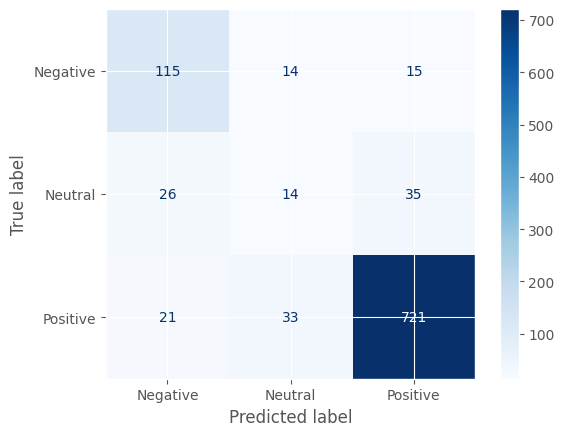

In [67]:
# Calculate the accuracy of RoBERTa prediction
accuracy = accuracy_score(review_data_roberta['sentiment_review'], review_data_roberta['sentiment_roberta'])

print("Accuracy: {}\n".format(accuracy))

# Show the classification report
print(classification_report(review_data_roberta['sentiment_review'], review_data_roberta['sentiment_roberta']))

# show confusion matrix
target_names = ['Negative', 'Neutral', 'Positive'] #goes from 0 - 5 
cm = confusion_matrix(review_data_roberta['sentiment_review'], review_data_roberta['sentiment_roberta'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

# Review comments that differ to what it's predicted

#### Checking VADER giving positive reviews to a 1-2 star review  and vice versa

In [90]:
# checking 1-2 star review but predicted 4-5 star by vader
rand_numb =3
example = review_data_vader[(review_data_vader['sentiment_review']== 'Negative') & 
                            (review_data_vader['sentiment_vader'] == 'Positive')].reset_index()

print("Rating from user: %d" % example['review score'][rand_numb])
print("Rating from VADER: %s" % example['sentiment_vader'][rand_numb])
print(example['review comment'][rand_numb])

Rating from user: 2
Rating from VADER: Positive
It is okay.  I would not go out of my way to buy it again


In [91]:
# checking 4-5 star review but predicted 1-2 star by vader
rand_numb =3
example = review_data_vader[(review_data_vader['sentiment_review']== 'Positive') & 
                            (review_data_vader['sentiment_vader'] == 'Negative')].reset_index()

print("Rating from user: %d" % example['review score'][rand_numb])
print("Rating from VADER: %s" % example['sentiment_vader'][rand_numb])
print(example['review comment'][rand_numb])

Rating from user: 5
Rating from VADER: Negative
This cat food was recommended by my vet because my 13 year old Cleo Cat was having trouble keeping any food down and was loosing weight.  It stopped her problems.  She doesn't eat as much as before since she seems to be more satisfied after eating which helps justify the added price.  It aids in digestion since the...ok sorry...smells are gone if ya know what I mean.  Had to add that so anyone experiencing problems with their cats can see there are a lot of benifits from this cat food.


#### Checking RoBERTa giving positive reviews to a 1-2 star review and vice versa

In [93]:
# checking 1-2 star review but predicted 4-5 star by roberta
rand_numb = 2
example = review_data_roberta[(review_data_roberta['sentiment_review']== 'Negative') & 
                            (review_data_roberta['sentiment_roberta'] == 'Positive')].reset_index()

print("Rating from user: %d" % example['review score'][rand_numb])
print("Rating from Roberta: %s" % example['sentiment_roberta'][rand_numb])
print(example['review comment'][rand_numb])

Rating from user: 2
Rating from Roberta: Positive
I was diappointed in the flavor and texture of this mix.  I usually like most of the Low Carb things I have tried, but was diappointed in this specific one.


In [95]:
# checking 4-5 star review but predicted 1-2 star by roberta
rand_numb = 2
example = review_data_roberta[(review_data_roberta['sentiment_review']== 'Positive') & 
                            (review_data_roberta['sentiment_roberta'] == 'Negative')].reset_index()

print("Rating from user: %d" % example['review score'][rand_numb])
print("Rating from Roberta: %s" % example['sentiment_roberta'][rand_numb])
print(example['review comment'][rand_numb])

Rating from user: 5
Rating from Roberta: Negative
this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault


## Summary
- VADER analyse almost x10 faster than RoBERTa (300 reviews per sec v 3 reviews per sec)
- RoBERTa is more accurate than VADER based on the 1000 reviews (85% v 81%)
- RoBERTa model takes time to load, sometimes it may run out of time when reading pre-trained model from RoBERTa
- RoBERTa couldn't handle large text size, this can be fixed?
- Low data quality such as typo can hinder the model performance